# Seq2seq NLG with Fastai

## Introduction

In this notebook, we perform Natural Language Generation (NLG) using the [e2e NLG Challenge](http://www.macs.hw.ac.uk/InteractionLab/E2E/) Dataset with the Fastai code provided [here](https://github.com/fastai/course-nlp) for seq2seq Machine Translation.

The Fastai library and code provides ready to use implementations of seq2seq algorithms such as RNN encoding-decoding with teacher forcing, as well as code for sampling output using top-p approach.

In NLG, instead of the source language as input and the target language as output, the input is the structured data or meaning representation and the output is the generated text.

### <u>Dataset</u>

The e2e Challenge dataset consists of 50k pairs of structured input (Meaning Representations or MRs) and short restaurant description output (NL for Natural Language) like this one:

**Input MR:**

    name[The Eagle],
    eatType[coffee shop],
    food[French],
    priceRange[moderate],
    customerRating[3/5],
    area[riverside],
    kidsFriendly[yes],
    near[Burger King]

**Output NL:**

    The three star coffee shop, The Eagle, gives families a mid-priced dining experience featuring a variety of wines and cheeses. Find The Eagle near Burger King.

The dataset is divided in about 90% training set and 10% validation set, with none of the inputs in the training set repeated in the validation set, even after removing venue names.

Another characteristic of the dataset is that the same MR can map to more than one text: there are only about 6k unique MRs.

### <u>Evaluation</u>

The systems submitted to this NLG challenge are evaluated on a test set of about 4k unseen pairs (and unseen MRs) against an attention-based seq2seq baseline that performs delexicalization (replacing principal and proximity venue names with the same generic name), data augmentation and reranking of the k-top beam search output using a classifier.

Evaluation scripts are provided [here](https://github.com/tuetschek/e2e-metrics). The measures used are Bleu, NIST, Meteor, Rouge-Lm and CiDer. These measures, despite their limitations, are used in Machine Translation, Text summarization and NLG. 

### <u>References</u>

- **Longer read:** [Evaluating the state-of-the-art of End-to-End Natural Language Generation: The E2E NLG challenge](https://www.sciencedirect.com/science/article/pii/S0885230819300919) <br>
Ondřej Dušek, Jekaterina Novikova and Verena Rieser <br>
*Computer Speech & Language*, Volume 59, January 2020, Pages 123-156
- **Shorter read:** [Findings of the E2E NLG Challenge](https://www.aclweb.org/anthology/W18-6539.pdf) <br>
Ondřej Dušek, Jekaterina Novikova and Verena Rieser <br>
*Proceedings of the 11th International Conference on Natural Language Generation*, 2018, Page 322–328.

## Let's start

First we delexicalize the data and load it into Fastai data structures, and we get the embeddings for both the input and output vocabularies using FastText pretrained embeddings. This is done in the following notebook:

In [1]:
# requires installing nbformat
%run init.ipynb

2019-12-29 21:35:21,882 - root - INFO - Maximum size for inputs and outputs is: 94

2019-12-29 21:35:23,526 - root - INFO - Size of input vocabulary=56
2019-12-29 21:35:23,527 - root - INFO - Size of output vocabulary=1216
2019-12-29 21:35:23,528 - root - INFO - Seq2SeqDataBunch;

Train: LabelList (42061 items)
x: Seq2SeqTextList
xxbos xxmaj the xxup xxx , coffee shop , xxmaj italian , customer rating low , price range less than £ 20 , family friendly yes , area riverside , near xxup yyy,xxbos xxup xxx , coffee shop , xxmaj italian , customer rating average , area city centre , near xxup yyy,xxbos xxup xxx , xxmaj english , family friendly yes , area riverside , near the xxup yyy,xxbos xxmaj the xxup xxx , coffee shop , xxmaj french , customer rating low , price range less than £ 20 , family friendly no , near xxup yyy,xxbos xxup xxx , coffee shop , xxmaj french , customer rating 3 out of 5 , price range high , family friendly yes , area riverside
y: TextList
xxbos xxmaj there is an in

xxunk
xxpad
xxbos
xxeos
xxfld
xxmaj
xxup
xxrep
xxwrep
xxunk
xxpad
xxbos
xxeos
xxfld
xxmaj
xxup
xxrep
xxwrep
n't
xxxs
clentele
d'oeuvres
yyyn
d'oeuvre
caféteria
xxfake
xxfake
xxfake
xxfake
xxfake
xxfake
2019-12-29 21:36:39,571 - root - INFO - Encoder embeddings saved to: ./enc_emb.pth
2019-12-29 21:36:39,574 - root - INFO - Encoder embeddings saved to: ./dec_emb.pth


/Users/nadjet/Work/seq2seq/seq2seq_venv/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Embedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [2]:
from seq2seq.seq2seq_tf import Seq2SeqRNN_tf

from utils.loss import Loss
from utils.bleu_callback import CorpusBLEU
from utils.teacher_forcing import TeacherForcing
from utils.metrics import Metrics
from utils.seq2seq_predict import *

from e2e_nlg.classification.mr_predictor import MrPredictor
from e2e_nlg.classification.reranker import Reranker

from fastai.text import Learner, partial

import random
import os

In [3]:
dl.max_size

94

In [4]:
HIDDEN_LAYER_SIZE = 128
MAX_SIZE = dl.max_size
emb_enc = embs.emb_enc
emb_dec = embs.emb_dec
data = dl.data
seq2seq_loss = Loss.seq2seq_loss
seq2seq_acc = Metrics.seq2seq_acc

Through experimentation, and despite the fact that most seq2seq approaches to the e2e NLG challenge use attention, I found that attention did not bring any improvement over plain RNN seq2seq.

The encoder-decoder uses teacher forcing, which means that, at training time, instead of feeding the output of the previous state to the next state, you feed it the real output so that errors in decoding in earlier stages do not propagate through the entire network. At prediction time, however, you do not have the real output, so you feed to the next state the prediction of the previous state. The `end_epoch` argument introduces an element of randomness to teacher forcing, so that

In [5]:
rnn_tf = Seq2SeqRNN_tf(emb_enc, emb_dec, HIDDEN_LAYER_SIZE, MAX_SIZE)

learn = Learner(data, rnn_tf, loss_func=seq2seq_loss, metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))],
               callback_fns=partial(TeacherForcing, end_epoch=20))

In [6]:
learn

Learner(data=Seq2SeqDataBunch;

Train: LabelList (42061 items)
x: Seq2SeqTextList
xxbos xxmaj the xxup xxx , coffee shop , xxmaj italian , customer rating low , price range less than £ 20 , family friendly yes , area riverside , near xxup yyy,xxbos xxup xxx , coffee shop , xxmaj italian , customer rating average , area city centre , near xxup yyy,xxbos xxup xxx , xxmaj english , family friendly yes , area riverside , near the xxup yyy,xxbos xxmaj the xxup xxx , coffee shop , xxmaj french , customer rating low , price range less than £ 20 , family friendly no , near xxup yyy,xxbos xxup xxx , coffee shop , xxmaj french , customer rating 3 out of 5 , price range high , family friendly yes , area riverside
y: TextList
xxbos xxmaj there is an inexpensive , family - friendly coffee shop near the river and xxup yyy . xxmaj it 's called xxmaj the xxup xxx and serves pasta .,xxbos xxmaj an xxmaj italian coffee shop with an average customer rating . xxup xxx is located near xxup yyy in the city 

## Training model

In [7]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.02E-03
Min loss divided by 10: 3.63E-04


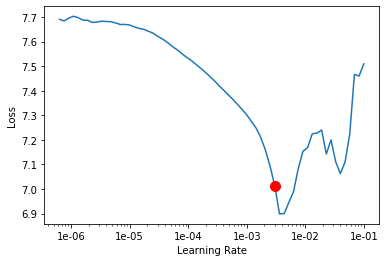

In [9]:
learn.recorder.plot(suggestion=True,skip_end=10)

In [10]:
learn.fit_one_cycle(10,3.02E-03)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,1.211004,6.811259,0.204587,0.281419,11:58
1,0.982699,6.316782,0.275177,0.375683,10:51
2,0.979583,6.297567,0.232438,0.370834,10:43
3,1.034650,5.660760,0.269278,0.414969,12:10


KeyboardInterrupt: 

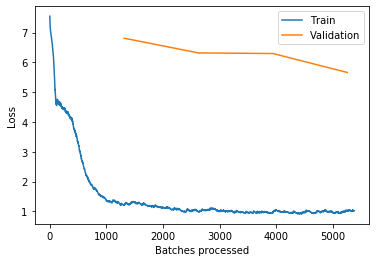

In [11]:
learn.recorder.plot_losses()

In [12]:
learn.save('model_tf', return_path=True)

PosixPath('models/model_tf.pth')

In [13]:
learn.export(file = 'learn.pkl')

## Greedy search

In [15]:
from fastai.text import load_learner
learn = load_learner("models","export.pkl")
#learn = load_learner("models","export_augmented.pkl")
learn.data = data

In [16]:
learn

Learner(data=Seq2SeqDataBunch;

Train: LabelList (42061 items)
x: Seq2SeqTextList
xxbos xxmaj the xxup xxx , coffee shop , xxmaj italian , customer rating low , price range less than £ 20 , family friendly yes , area riverside , near xxup yyy,xxbos xxup xxx , coffee shop , xxmaj italian , customer rating average , area city centre , near xxup yyy,xxbos xxup xxx , xxmaj english , family friendly yes , area riverside , near the xxup yyy,xxbos xxmaj the xxup xxx , coffee shop , xxmaj french , customer rating low , price range less than £ 20 , family friendly no , near xxup yyy,xxbos xxup xxx , coffee shop , xxmaj french , customer rating 3 out of 5 , price range high , family friendly yes , area riverside
y: TextList
xxbos xxmaj there is an inexpensive , family - friendly coffee shop near the river and xxup yyy . xxmaj it 's called xxmaj the xxup xxx and serves pasta .,xxbos xxmaj an xxmaj italian coffee shop with an average customer rating . xxup xxx is located near xxup yyy in the city 

In [17]:
learn.data

Seq2SeqDataBunch;

Train: LabelList (42061 items)
x: Seq2SeqTextList
xxbos xxmaj the xxup xxx , coffee shop , xxmaj italian , customer rating low , price range less than £ 20 , family friendly yes , area riverside , near xxup yyy,xxbos xxup xxx , coffee shop , xxmaj italian , customer rating average , area city centre , near xxup yyy,xxbos xxup xxx , xxmaj english , family friendly yes , area riverside , near the xxup yyy,xxbos xxmaj the xxup xxx , coffee shop , xxmaj french , customer rating low , price range less than £ 20 , family friendly no , near xxup yyy,xxbos xxup xxx , coffee shop , xxmaj french , customer rating 3 out of 5 , price range high , family friendly yes , area riverside
y: TextList
xxbos xxmaj there is an inexpensive , family - friendly coffee shop near the river and xxup yyy . xxmaj it 's called xxmaj the xxup xxx and serves pasta .,xxbos xxmaj an xxmaj italian coffee shop with an average customer rating . xxup xxx is located near xxup yyy in the city centre .,xxbo

We generate output texts given top prediction given by greedy search.

In [14]:
seq2seq_predictor = PredictUtils(learn)

In [15]:
inputs, targets, outputs = seq2seq_predictor.get_predictions()

In [16]:
mr_predictor = MrPredictor(os.path.join(main_path,"models","classifier"), dataset_path)

In [18]:
from csv import writer
import re
from e2e_nlg.formatting.mrs_formatter import MR_Formatter
rows = []
num_pr=0
num_rec=0
with open(os.path.join(out_path,"dev_greedy.csv"),"w") as f:
    w = writer(f,delimiter="\t")
    w.writerow(["input","output","target","input mrs","output mrs","pr","rec"])
    for i in range(len(inputs)):
        if i%10==0:
            print(i,num_pr,num_rec)
        output_predictions = str(mr_predictor.predict(outputs[i])[0])
        output_predictions = sorted(list(set([item.strip() for item in output_predictions.split(";")])))
        mr_formatter = MR_Formatter(str(inputs[i]))
        mr_formatter.set_attributes()
        mr_formatter.attributes.remove('name[XXX]')
        input_predictions = sorted(mr_formatter.attributes)
        input_predictions = Reranker.check_predictions(input_predictions,is_input=True)
        output_predictions = Reranker.check_predictions(output_predictions,is_input=True)
        pr = PredictUtils.calculate_precision(input_predictions, output_predictions)
        rec = PredictUtils.calculate_recall(input_predictions, output_predictions)
        if pr<1:
            num_pr=num_pr+1
        if rec<1:
            num_rec=num_rec+1
        #outputs[i] = re.sub(r"\. xxmaj the xxup xxx ",". xxmaj it ",str(outputs[i]))
        #outputs[i] = re.sub(r"\. xxmaj xxup xxx ",". xxmaj it ",str(outputs[i]))
        row = [inputs[i],outputs[i],targets[i],",".join(input_predictions),",".join(output_predictions),pr,rec]
        rows.append(row)
        w.writerow(row)

0 0 0
10 0 6
20 3 12
30 5 17
40 9 24
50 13 32
60 15 37
70 19 43
80 19 49
90 20 55
100 21 60
110 21 67
120 23 70
130 24 78
140 26 82
150 28 90
160 28 94
170 29 99
180 30 106
190 31 114
200 31 121
210 32 125
220 33 134
230 33 142
240 33 151
250 33 161
260 35 167
270 36 174
280 36 181
290 36 191
300 36 197
310 37 205
320 37 213
330 37 221
340 38 231
350 39 238
360 39 246
370 43 253
380 46 261
390 47 264
400 50 267
410 51 270
420 52 277
430 52 285
440 52 290
450 53 297
460 53 305
470 53 310
480 53 318
490 53 324
500 54 330
510 54 340
520 55 347
530 56 356
540 57 363
550 58 372
560 61 380
570 61 388
580 63 396
590 65 401
600 65 408
610 65 415
620 65 420
630 66 428
640 66 436
650 67 444
660 68 454
670 68 461
680 71 468
690 73 470
700 73 474
710 76 475
720 77 476
730 79 477
740 82 478
750 86 481
760 90 482
770 94 483
780 99 486
790 103 486
800 106 489
810 112 490
820 114 495
830 117 499
840 117 500
850 120 502
860 124 506
870 125 508
880 127 512
890 128 517
900 131 525
910 132 527
920 133 531

In [22]:
df = pd.DataFrame(rows)

In [23]:
df.sample(5)

,0,1,2
945,"xxbos xxup xxx , coffee shop , xxmaj english , customer rating 1 out of 5 , price range high , family friendly yes , area city centre","xxbos xxup xxx is a high priced , child friendly , xxmaj english coffee shop in the city centre . xxmaj it has a customer rating of 1 out of 5 .","xxbos xxmaj yes , this restaurant is child friendly where they serve xxmaj english food . xxmaj this place is called xxup xxx after the xxunk . xxmaj they recently xxunk to city centre where the area rates 1 out of 5 . xxmaj they are xxunk by a coffee shop and xxunk xxunk where the prices are high ."
704,"xxbos xxup xxx , coffee shop , xxmaj english , customer rating high , price range more than £ 30 , area city centre , near the xxup yyy",xxbos xxmaj there is a high rated xxmaj english coffee shop called xxup xxx in the city centre near xxmaj the xxup yyy . xxmaj it has a price range of more than £ 30 .,"xxbos xxup xxx is a coffee shop style eatery serving xxmaj english food at prices averaging over £ 30 . xxmaj highly rated , it is located in the city centre close to xxmaj the xxup yyy ."
1258,"xxbos xxmaj the xxup xxx , coffee shop , xxmaj chinese , customer rating 5 out of 5 , family friendly yes , near the xxup yyy",xxbos xxmaj the xxup xxx is a family friendly coffee shop that serves xxmaj chinese food . xxmaj it has a customer rating of 5 out of 5 and is located near xxmaj the xxup yyy .,xxbos xxmaj the xxup xxx coffee shop offers great xxmaj chinese food and is rated a 5 out of 5 . xxmaj xxunk is located near xxmaj the xxup yyy and is family friendly .
3505,"xxbos xxup xxx , coffee shop , xxmaj english , family friendly yes , area riverside , near xxup yyy",xxbos xxmaj there is a family friendly coffee shop called xxup xxx that serves xxmaj english food . xxmaj it is located in the riverside area near xxup yyy .,xxbos xxmaj in riverside there is a coffee shop near xxup yyy called xxup xxx . xxmaj it is kid friendly with xxmaj english food .
2230,"xxbos xxup xxx , coffee shop , xxmaj chinese , customer rating 5 out of 5 , family friendly no , area city centre",xxbos xxup xxx is a xxmaj chinese coffee shop in the city centre . xxmaj it has a customer rating of 5 out of 5 and is not family friendly .,xxbos xxup xxx is a coffee shop and also offer xxmaj chinese food . xxmaj we have a customer rating of 5 out of 5 . xxmaj located in city center . xxmaj unfortunately not family friendly .


In [42]:
df[df[5]<1].sample(5)

,0,1,2,3,4,5,6
801,"xxbos xxup xxx , coffee shop , xxmaj chinese , customer rating low , price range less than £ 20 , area city centre , near the xxup yyy",xxbos xxup xxx is a coffee shop providing xxmaj chinese food in the less than £ 20 price range . xxmaj it is located in the city centre . xxmaj it is near xxmaj the xxup yyy . xxmaj its customer rating is low .,xxbos xxup xxx is a coffee shop serving xxmaj chinese dishes in the city centre near xxmaj the xxup yyy . xxmaj its prices are less than twenty xxmaj euro with low ratings .,"area[city centre],customer rating[1],eatType[coffee shop],food[Chinese],near[yes],priceRange[1]","area[city centre],customer rating[1],eatType[coffee shop],familyFriendly[no],food[Chinese],near[yes],priceRange[1]",0.857143,1.000000
1103,"xxbos xxup xxx , coffee shop , xxmaj chinese , customer rating 5 out of 5 , price range cheap , area riverside , near the xxup yyy",xxbos xxup xxx is a coffee shop providing xxmaj chinese food in the cheap price range . xxmaj it is located in the riverside . xxmaj it is near xxmaj the xxup yyy . xxmaj its customer rating is 5 out of 5 .,xxbos xxup xxx is a coffee shop providing xxmaj chinese food in the cheap price range . xxmaj it is located in the riverside . xxmaj it is near xxmaj the xxup yyy . xxmaj its customer rating is 5 out of 5 .,"area[riverside],customer rating[3],eatType[coffee shop],food[Chinese],near[yes],priceRange[1]","area[riverside],customer rating[3],eatType[coffee shop],familyFriendly[no],food[Chinese],near[yes],priceRange[1]",0.857143,1.000000
1726,"xxbos xxmaj the xxup xxx , coffee shop , xxmaj english , price range high , family friendly yes , area riverside , near xxup yyy",xxbos xxmaj the xxup xxx is a high priced coffee shop that serves xxmaj english food . xxmaj it is located in the riverside area near xxup yyy . xxmaj it is children friendly and has a high customer rating .,xxbos xxmaj the xxup xxx its a restaurant for all family with good food located near xxup yyy,"area[riverside],eatType[coffee shop],familyFriendly[yes],food[English],near[yes],priceRange[3]","area[riverside],customer rating[3],eatType[coffee shop],familyFriendly[yes],food[English],near[yes]",0.833333,0.833333
24,"xxbos xxmaj the xxup xxx , coffee shop , xxmaj chinese , customer rating low , price range less than £ 20 , family friendly yes , area city centre , near xxup yyy",xxbos xxmaj the xxup xxx is a coffee shop providing xxmaj chinese food in the less than £ 20 price range . xxmaj it is located in the city centre . xxmaj it is near xxup yyy . xxmaj its customer rating is low .,xxbos xxmaj the xxup xxx is a family friendly coffee shop that serves xxmaj chinese food with a price range of less than £ 20 and has a low customer rating . xxmaj it is located near xxup yyy in the center . of the city .,"area[city centre],customer rating[1],eatType[coffee shop],familyFriendly[yes],food[Chinese],near[yes],priceRange[1]","area[city centre],customer rating[1],eatType[coffee shop],familyFriendly[no],food[Chinese],near[yes],priceRange[1]",0.857143,0.857143
765,"xxbos xxup xxx , coffee shop , xxmaj chinese , customer rating 5 out of 5 , price range cheap , area city centre , near the xxup yyy",xxbos xxup xxx is a coffee shop providing xxmaj chinese food in the cheap price range . xxmaj it is located in the city centre . xxmaj it is near xxmaj the xxup yyy . xxmaj its customer rating is 5 out of 5 .,"xxbos xxup xxx , a coffee shop type of restaurant offering xxmaj chinese cuisine in the cheaper price range with a 5 out of 5 customer rating and is located in the city centre area near xxmaj the xxup yyy .","area[city centre],customer rating[3],eatType[coffee shop],food[Chinese],near[yes],priceRange[1]","area[city centre],customer rating[3],eatType[coffee shop],familyFriendly[no],food[Chinese],near[yes],priceRange[1]",0.857143,1.000000


In [45]:
df[df[5]<1].shape[0]

251

# Top-p sampling with reranking

In [5]:
from fastai.text import load_learner
learn = load_learner("models","export.pkl")
dl = E2ENLGDataLoader(dataset_path,"trainset.csv","testset_w_refs.csv",percentile=100)
dl.setDataAndMaxSize(bs=32)
learn.data = dl.data

2019-12-29 21:40:04,087 - root - INFO - Maximum size for inputs and outputs is: 94

2019-12-29 21:40:05,743 - root - INFO - Size of input vocabulary=56
2019-12-29 21:40:05,744 - root - INFO - Size of output vocabulary=1216
2019-12-29 21:40:05,745 - root - INFO - Seq2SeqDataBunch;

Train: LabelList (42061 items)
x: Seq2SeqTextList
xxbos xxmaj the xxup xxx , coffee shop , xxmaj italian , customer rating low , price range less than £ 20 , family friendly yes , area riverside , near xxup yyy,xxbos xxup xxx , coffee shop , xxmaj italian , customer rating average , area city centre , near xxup yyy,xxbos xxup xxx , xxmaj english , family friendly yes , area riverside , near the xxup yyy,xxbos xxmaj the xxup xxx , coffee shop , xxmaj french , customer rating low , price range less than £ 20 , family friendly no , near xxup yyy,xxbos xxup xxx , coffee shop , xxmaj french , customer rating 3 out of 5 , price range high , family friendly yes , area riverside
y: TextList
xxbos xxmaj there is an in

For reranking, I select the top-k candidates using neural sampling. Out of these sampled candidates, I select the one with highest F1 score between output MRs and reference MRs. For equivalent F1 scores, I choose the output with the highest mean probability. 

In [6]:
learn.data

Seq2SeqDataBunch;

Train: LabelList (42061 items)
x: Seq2SeqTextList
xxbos xxmaj the xxup xxx , coffee shop , xxmaj italian , customer rating low , price range less than £ 20 , family friendly yes , area riverside , near xxup yyy,xxbos xxup xxx , coffee shop , xxmaj italian , customer rating average , area city centre , near xxup yyy,xxbos xxup xxx , xxmaj english , family friendly yes , area riverside , near the xxup yyy,xxbos xxmaj the xxup xxx , coffee shop , xxmaj french , customer rating low , price range less than £ 20 , family friendly no , near xxup yyy,xxbos xxup xxx , coffee shop , xxmaj french , customer rating 3 out of 5 , price range high , family friendly yes , area riverside
y: TextList
xxbos xxmaj there is an inexpensive , family - friendly coffee shop near the river and xxup yyy . xxmaj it 's called xxmaj the xxup xxx and serves pasta .,xxbos xxmaj an xxmaj italian coffee shop with an average customer rating . xxup xxx is located near xxup yyy in the city centre .,xxbo

In [7]:
seq2seq_pred = PredictUtils(learn)

In [8]:
rxs,rys,rzs,xs,ys,zs = seq2seq_pred.preds_acts()

In [9]:
mr_predictor = MrPredictor(os.path.join(main_path,"models","classifier"), dataset_path)

In [10]:
reranker = Reranker(mr_predictor,seq2seq_pred, k=20, p=0.3, T=1)

2019-12-29 21:41:00,026 - root - INFO - p=0.3, k=20, T=1


In [11]:
reranker.p, reranker.k, reranker.T

(0.3, 20, 1)

In [12]:
from csv import writer
counter=0
with open(os.path.join(out_path,"reranker_dev.csv"),"w") as f:
    if counter%100==0:
        print(counter)
    counter=counter+1
    w = writer(f,delimiter ='\t')
    w.writerow(["different","output","f1","old_output","input","target"])
    for row in reranker.rerank_generator(xs, ys, zs, rxs, rys, rzs):
        w.writerow(row)

0
2019-12-29 21:41:00,350 - root - INFO - 0 0
2019-12-29 21:41:00,615 - root - INFO - 0 1
2019-12-29 21:41:00,869 - root - INFO - 0 2
2019-12-29 21:41:01,137 - root - INFO - 0 3
2019-12-29 21:41:06,946 - root - INFO - 1 4
2019-12-29 21:41:12,945 - root - INFO - 2 5
2019-12-29 21:41:13,209 - root - INFO - 2 6
2019-12-29 21:41:19,232 - root - INFO - 3 7
2019-12-29 21:41:25,338 - root - INFO - 4 8
2019-12-29 21:41:31,851 - root - INFO - 5 9
2019-12-29 21:41:37,666 - root - INFO - 6 10
2019-12-29 21:41:37,944 - root - INFO - 6 11
2019-12-29 21:41:43,857 - root - INFO - 7 12
2019-12-29 21:41:49,607 - root - INFO - 8 13
2019-12-29 21:41:55,741 - root - INFO - 9 14
2019-12-29 21:42:01,775 - root - INFO - 10 15
2019-12-29 21:42:02,038 - root - INFO - 10 16
2019-12-29 21:42:02,291 - root - INFO - 10 17
2019-12-29 21:42:08,460 - root - INFO - 11 18
2019-12-29 21:42:14,608 - root - INFO - 12 19
2019-12-29 21:42:14,870 - root - INFO - 12 20
2019-12-29 21:42:20,875 - root - INFO - 13 21
2019-12-29 

2019-12-29 21:53:17,967 - root - INFO - 124 177
2019-12-29 21:53:18,222 - root - INFO - 124 178
2019-12-29 21:53:24,003 - root - INFO - 125 179
2019-12-29 21:53:29,808 - root - INFO - 126 180
2019-12-29 21:53:35,600 - root - INFO - 127 181
2019-12-29 21:53:41,095 - root - INFO - 128 182
2019-12-29 21:53:47,125 - root - INFO - 129 183
2019-12-29 21:53:50,605 - root - INFO - 130 184
2019-12-29 21:53:56,357 - root - INFO - 131 185
2019-12-29 21:54:01,828 - root - INFO - 132 186
2019-12-29 21:54:02,070 - root - INFO - 132 187
2019-12-29 21:54:02,308 - root - INFO - 132 188
2019-12-29 21:54:07,861 - root - INFO - 133 189
2019-12-29 21:54:10,130 - root - INFO - 133 190
2019-12-29 21:54:14,115 - root - INFO - 134 191
2019-12-29 21:54:14,349 - root - INFO - 134 192
2019-12-29 21:54:18,023 - root - INFO - 135 193
2019-12-29 21:54:18,267 - root - INFO - 135 194
2019-12-29 21:54:21,400 - root - INFO - 135 195
2019-12-29 21:54:23,685 - root - INFO - 136 196
2019-12-29 21:54:23,925 - root - INFO - 

2019-12-29 22:03:24,463 - root - INFO - 213 348
2019-12-29 22:03:31,164 - root - INFO - 214 349
2019-12-29 22:03:36,204 - root - INFO - 214 350
2019-12-29 22:03:43,007 - root - INFO - 215 351
2019-12-29 22:03:48,260 - root - INFO - 216 352
2019-12-29 22:03:51,048 - root - INFO - 216 353
2019-12-29 22:03:55,000 - root - INFO - 216 354
2019-12-29 22:03:56,971 - root - INFO - 217 355
2019-12-29 22:04:03,054 - root - INFO - 217 356
2019-12-29 22:04:04,248 - root - INFO - 217 357
2019-12-29 22:04:10,210 - root - INFO - 218 358
2019-12-29 22:04:11,342 - root - INFO - 218 359
2019-12-29 22:04:17,035 - root - INFO - 219 360
2019-12-29 22:04:20,984 - root - INFO - 219 361
2019-12-29 22:04:21,233 - root - INFO - 219 362
2019-12-29 22:04:27,502 - root - INFO - 220 363
2019-12-29 22:04:31,779 - root - INFO - 220 364
2019-12-29 22:04:33,160 - root - INFO - 220 365
2019-12-29 22:04:34,531 - root - INFO - 220 366
2019-12-29 22:04:37,496 - root - INFO - 220 367
2019-12-29 22:04:43,984 - root - INFO - 

2019-12-29 22:14:12,244 - root - INFO - 309 519
2019-12-29 22:14:17,517 - root - INFO - 309 520
2019-12-29 22:14:20,947 - root - INFO - 310 521
2019-12-29 22:14:25,070 - root - INFO - 310 522
2019-12-29 22:14:28,274 - root - INFO - 311 523
2019-12-29 22:14:31,887 - root - INFO - 312 524
2019-12-29 22:14:36,601 - root - INFO - 312 525
2019-12-29 22:14:41,763 - root - INFO - 313 526
2019-12-29 22:14:47,465 - root - INFO - 313 527
2019-12-29 22:14:52,559 - root - INFO - 314 528
2019-12-29 22:14:54,970 - root - INFO - 314 529
2019-12-29 22:14:57,884 - root - INFO - 314 530
2019-12-29 22:14:58,988 - root - INFO - 314 531
2019-12-29 22:14:59,244 - root - INFO - 314 532
2019-12-29 22:15:04,667 - root - INFO - 314 533
2019-12-29 22:15:10,256 - root - INFO - 314 534
2019-12-29 22:15:15,977 - root - INFO - 315 535
2019-12-29 22:15:21,795 - root - INFO - 316 536
2019-12-29 22:15:25,935 - root - INFO - 317 537
2019-12-29 22:15:28,122 - root - INFO - 317 538
2019-12-29 22:15:28,372 - root - INFO - 

2019-12-29 22:24:33,597 - root - INFO - 393 690
2019-12-29 22:24:34,745 - root - INFO - 393 691
2019-12-29 22:24:34,998 - root - INFO - 393 692
2019-12-29 22:24:40,788 - root - INFO - 393 693
2019-12-29 22:24:46,426 - root - INFO - 394 694
2019-12-29 22:24:50,043 - root - INFO - 395 695
2019-12-29 22:24:54,002 - root - INFO - 395 696
2019-12-29 22:24:59,438 - root - INFO - 396 697
2019-12-29 22:25:01,820 - root - INFO - 396 698
2019-12-29 22:25:07,596 - root - INFO - 397 699
2019-12-29 22:25:09,966 - root - INFO - 397 700
2019-12-29 22:25:10,201 - root - INFO - 397 701
2019-12-29 22:25:12,039 - root - INFO - 397 702
2019-12-29 22:25:17,644 - root - INFO - 398 703
2019-12-29 22:25:20,011 - root - INFO - 398 704
2019-12-29 22:25:20,249 - root - INFO - 398 705
2019-12-29 22:25:21,337 - root - INFO - 398 706
2019-12-29 22:25:26,691 - root - INFO - 399 707
2019-12-29 22:25:31,967 - root - INFO - 400 708
2019-12-29 22:25:34,589 - root - INFO - 400 709
2019-12-29 22:25:40,050 - root - INFO - 

2019-12-29 22:35:26,671 - root - INFO - 489 861
2019-12-29 22:35:32,754 - root - INFO - 490 862
2019-12-29 22:35:38,387 - root - INFO - 491 863
2019-12-29 22:35:39,525 - root - INFO - 491 864
2019-12-29 22:35:43,473 - root - INFO - 492 865
2019-12-29 22:35:44,622 - root - INFO - 492 866
2019-12-29 22:35:50,372 - root - INFO - 493 867
2019-12-29 22:35:56,203 - root - INFO - 494 868
2019-12-29 22:36:02,161 - root - INFO - 495 869
2019-12-29 22:36:04,209 - root - INFO - 495 870
2019-12-29 22:36:08,352 - root - INFO - 496 871
2019-12-29 22:36:11,873 - root - INFO - 496 872
2019-12-29 22:36:13,017 - root - INFO - 496 873
2019-12-29 22:36:18,940 - root - INFO - 497 874
2019-12-29 22:36:20,018 - root - INFO - 497 875
2019-12-29 22:36:22,729 - root - INFO - 497 876
2019-12-29 22:36:28,433 - root - INFO - 498 877
2019-12-29 22:36:34,627 - root - INFO - 499 878
2019-12-29 22:36:38,429 - root - INFO - 500 879
2019-12-29 22:36:43,909 - root - INFO - 501 880
2019-12-29 22:36:50,045 - root - INFO - 

2019-12-29 22:47:52,358 - root - INFO - 596 1032
2019-12-29 22:47:53,497 - root - INFO - 596 1033
2019-12-29 22:48:00,152 - root - INFO - 597 1034
2019-12-29 22:48:00,441 - root - INFO - 597 1035
2019-12-29 22:48:06,789 - root - INFO - 597 1036
2019-12-29 22:48:12,752 - root - INFO - 598 1037
2019-12-29 22:48:13,025 - root - INFO - 598 1038
2019-12-29 22:48:18,896 - root - INFO - 599 1039
2019-12-29 22:48:24,981 - root - INFO - 600 1040
2019-12-29 22:48:25,240 - root - INFO - 600 1041
2019-12-29 22:48:30,449 - root - INFO - 601 1042
2019-12-29 22:48:36,992 - root - INFO - 602 1043
2019-12-29 22:48:38,161 - root - INFO - 602 1044
2019-12-29 22:48:43,080 - root - INFO - 603 1045
2019-12-29 22:48:48,963 - root - INFO - 604 1046
2019-12-29 22:48:54,580 - root - INFO - 605 1047
2019-12-29 22:49:00,863 - root - INFO - 605 1048
2019-12-29 22:49:06,380 - root - INFO - 606 1049
2019-12-29 22:49:10,705 - root - INFO - 607 1050
2019-12-29 22:49:16,263 - root - INFO - 608 1051
2019-12-29 22:49:22,

2019-12-29 22:59:44,592 - root - INFO - 707 1200
2019-12-29 22:59:50,371 - root - INFO - 708 1201
2019-12-29 22:59:54,297 - root - INFO - 709 1202
2019-12-29 23:00:00,998 - root - INFO - 710 1203
2019-12-29 23:00:05,330 - root - INFO - 711 1204
2019-12-29 23:00:08,788 - root - INFO - 712 1205
2019-12-29 23:00:13,208 - root - INFO - 712 1206
2019-12-29 23:00:18,073 - root - INFO - 712 1207
2019-12-29 23:00:22,591 - root - INFO - 713 1208
2019-12-29 23:00:28,604 - root - INFO - 714 1209
2019-12-29 23:00:34,737 - root - INFO - 715 1210
2019-12-29 23:00:40,446 - root - INFO - 716 1211
2019-12-29 23:00:45,378 - root - INFO - 716 1212
2019-12-29 23:00:46,513 - root - INFO - 716 1213
2019-12-29 23:00:50,563 - root - INFO - 717 1214
2019-12-29 23:00:56,317 - root - INFO - 718 1215
2019-12-29 23:01:02,112 - root - INFO - 719 1216
2019-12-29 23:01:07,544 - root - INFO - 720 1217
2019-12-29 23:01:13,478 - root - INFO - 721 1218
2019-12-29 23:01:16,064 - root - INFO - 722 1219
2019-12-29 23:01:22,

2019-12-29 23:11:40,692 - root - INFO - 821 1368
2019-12-29 23:11:44,144 - root - INFO - 822 1369
2019-12-29 23:11:48,168 - root - INFO - 823 1370
2019-12-29 23:11:53,545 - root - INFO - 824 1371
2019-12-29 23:11:59,044 - root - INFO - 825 1372
2019-12-29 23:12:04,901 - root - INFO - 826 1373
2019-12-29 23:12:05,976 - root - INFO - 826 1374
2019-12-29 23:12:10,891 - root - INFO - 826 1375
2019-12-29 23:12:11,954 - root - INFO - 826 1376
2019-12-29 23:12:15,955 - root - INFO - 827 1377
2019-12-29 23:12:17,036 - root - INFO - 827 1378
2019-12-29 23:12:22,138 - root - INFO - 828 1379
2019-12-29 23:12:27,997 - root - INFO - 829 1380
2019-12-29 23:12:34,072 - root - INFO - 830 1381
2019-12-29 23:12:35,162 - root - INFO - 830 1382
2019-12-29 23:12:36,272 - root - INFO - 830 1383
2019-12-29 23:12:41,236 - root - INFO - 831 1384
2019-12-29 23:12:47,968 - root - INFO - 832 1385
2019-12-29 23:12:51,076 - root - INFO - 833 1386
2019-12-29 23:12:58,012 - root - INFO - 834 1387
2019-12-29 23:13:01,

2019-12-29 23:23:30,853 - root - INFO - 918 1536
2019-12-29 23:23:32,086 - root - INFO - 918 1537
2019-12-29 23:23:35,327 - root - INFO - 918 1538
2019-12-29 23:23:40,997 - root - INFO - 919 1539
2019-12-29 23:23:47,161 - root - INFO - 920 1540
2019-12-29 23:23:52,678 - root - INFO - 921 1541
2019-12-29 23:23:55,315 - root - INFO - 921 1542
2019-12-29 23:24:00,645 - root - INFO - 922 1543
2019-12-29 23:24:01,755 - root - INFO - 922 1544
2019-12-29 23:24:07,311 - root - INFO - 923 1545
2019-12-29 23:24:12,383 - root - INFO - 923 1546
2019-12-29 23:24:18,391 - root - INFO - 924 1547
2019-12-29 23:24:23,793 - root - INFO - 925 1548
2019-12-29 23:24:26,428 - root - INFO - 925 1549
2019-12-29 23:24:28,477 - root - INFO - 926 1550
2019-12-29 23:24:34,092 - root - INFO - 927 1551
2019-12-29 23:24:36,982 - root - INFO - 927 1552
2019-12-29 23:24:42,199 - root - INFO - 928 1553
2019-12-29 23:24:44,716 - root - INFO - 928 1554
2019-12-29 23:24:50,029 - root - INFO - 929 1555
2019-12-29 23:24:52,

2019-12-29 23:31:57,643 - root - INFO - 979 1704
2019-12-29 23:32:03,515 - root - INFO - 980 1705
2019-12-29 23:32:04,547 - root - INFO - 980 1706
2019-12-29 23:32:07,128 - root - INFO - 980 1707
2019-12-29 23:32:07,378 - root - INFO - 980 1708
2019-12-29 23:32:08,677 - root - INFO - 980 1709
2019-12-29 23:32:08,918 - root - INFO - 980 1710
2019-12-29 23:32:10,179 - root - INFO - 980 1711
2019-12-29 23:32:10,424 - root - INFO - 980 1712
2019-12-29 23:32:10,672 - root - INFO - 980 1713
2019-12-29 23:32:10,917 - root - INFO - 980 1714
2019-12-29 23:32:15,049 - root - INFO - 980 1715
2019-12-29 23:32:19,949 - root - INFO - 980 1716
2019-12-29 23:32:20,176 - root - INFO - 980 1717
2019-12-29 23:32:21,381 - root - INFO - 980 1718
2019-12-29 23:32:27,159 - root - INFO - 981 1719
2019-12-29 23:32:28,183 - root - INFO - 981 1720
2019-12-29 23:32:31,515 - root - INFO - 981 1721
2019-12-29 23:32:31,755 - root - INFO - 981 1722
2019-12-29 23:32:32,805 - root - INFO - 981 1723
2019-12-29 23:32:38,

2019-12-29 23:40:34,849 - root - INFO - 1036 1870
2019-12-29 23:40:39,413 - root - INFO - 1037 1871
2019-12-29 23:40:40,451 - root - INFO - 1037 1872
2019-12-29 23:40:43,022 - root - INFO - 1038 1873
2019-12-29 23:40:48,492 - root - INFO - 1039 1874
2019-12-29 23:40:52,156 - root - INFO - 1040 1875
2019-12-29 23:40:57,965 - root - INFO - 1041 1876
2019-12-29 23:41:00,115 - root - INFO - 1041 1877
2019-12-29 23:41:05,346 - root - INFO - 1042 1878
2019-12-29 23:41:05,582 - root - INFO - 1042 1879
2019-12-29 23:41:07,665 - root - INFO - 1043 1880
2019-12-29 23:41:08,971 - root - INFO - 1043 1881
2019-12-29 23:41:14,260 - root - INFO - 1043 1882
2019-12-29 23:41:17,785 - root - INFO - 1043 1883
2019-12-29 23:41:18,790 - root - INFO - 1043 1884
2019-12-29 23:41:19,793 - root - INFO - 1043 1885
2019-12-29 23:41:25,184 - root - INFO - 1044 1886
2019-12-29 23:41:30,999 - root - INFO - 1045 1887
2019-12-29 23:41:31,237 - root - INFO - 1045 1888
2019-12-29 23:41:31,458 - root - INFO - 1045 1889


2019-12-29 23:49:07,947 - root - INFO - 1089 2034
2019-12-29 23:49:13,156 - root - INFO - 1090 2035
2019-12-29 23:49:17,625 - root - INFO - 1090 2036
2019-12-29 23:49:23,422 - root - INFO - 1090 2037
2019-12-29 23:49:27,940 - root - INFO - 1090 2038
2019-12-29 23:49:28,203 - root - INFO - 1090 2039
2019-12-29 23:49:28,452 - root - INFO - 1090 2040
2019-12-29 23:49:32,609 - root - INFO - 1090 2041
2019-12-29 23:49:33,625 - root - INFO - 1090 2042
2019-12-29 23:49:33,873 - root - INFO - 1090 2043
2019-12-29 23:49:40,912 - root - INFO - 1091 2044
2019-12-29 23:49:47,020 - root - INFO - 1091 2045
2019-12-29 23:49:50,833 - root - INFO - 1091 2046
2019-12-29 23:49:56,729 - root - INFO - 1092 2047
2019-12-29 23:49:56,981 - root - INFO - 1092 2048
2019-12-29 23:50:02,598 - root - INFO - 1092 2049
2019-12-29 23:50:08,401 - root - INFO - 1093 2050
2019-12-29 23:50:09,415 - root - INFO - 1093 2051
2019-12-29 23:50:13,160 - root - INFO - 1093 2052
2019-12-29 23:50:14,301 - root - INFO - 1093 2053


2019-12-29 23:58:12,874 - root - INFO - 1144 2198
2019-12-29 23:58:15,506 - root - INFO - 1144 2199
2019-12-29 23:58:16,476 - root - INFO - 1144 2200
2019-12-29 23:58:16,716 - root - INFO - 1144 2201
2019-12-29 23:58:16,954 - root - INFO - 1144 2202
2019-12-29 23:58:22,448 - root - INFO - 1145 2203
2019-12-29 23:58:25,724 - root - INFO - 1145 2204
2019-12-29 23:58:29,995 - root - INFO - 1145 2205
2019-12-29 23:58:30,275 - root - INFO - 1145 2206
2019-12-29 23:58:30,545 - root - INFO - 1145 2207
2019-12-29 23:58:33,689 - root - INFO - 1146 2208
2019-12-29 23:58:37,318 - root - INFO - 1146 2209
2019-12-29 23:58:37,567 - root - INFO - 1146 2210
2019-12-29 23:58:37,826 - root - INFO - 1146 2211
2019-12-29 23:58:41,051 - root - INFO - 1147 2212
2019-12-29 23:58:42,144 - root - INFO - 1147 2213
2019-12-29 23:58:48,849 - root - INFO - 1147 2214
2019-12-29 23:58:52,479 - root - INFO - 1147 2215
2019-12-29 23:58:55,321 - root - INFO - 1147 2216
2019-12-29 23:58:55,691 - root - INFO - 1147 2217


2019-12-30 00:07:32,564 - root - INFO - 1200 2362
2019-12-30 00:07:36,108 - root - INFO - 1200 2363
2019-12-30 00:07:37,188 - root - INFO - 1200 2364
2019-12-30 00:07:42,929 - root - INFO - 1200 2365
2019-12-30 00:07:48,054 - root - INFO - 1201 2366
2019-12-30 00:07:48,312 - root - INFO - 1201 2367
2019-12-30 00:07:49,359 - root - INFO - 1201 2368
2019-12-30 00:07:49,610 - root - INFO - 1201 2369
2019-12-30 00:07:49,853 - root - INFO - 1201 2370
2019-12-30 00:07:50,102 - root - INFO - 1201 2371
2019-12-30 00:07:54,076 - root - INFO - 1201 2372
2019-12-30 00:07:57,962 - root - INFO - 1202 2373
2019-12-30 00:08:02,740 - root - INFO - 1202 2374
2019-12-30 00:08:08,146 - root - INFO - 1202 2375
2019-12-30 00:08:10,731 - root - INFO - 1202 2376
2019-12-30 00:08:13,675 - root - INFO - 1203 2377
2019-12-30 00:08:18,987 - root - INFO - 1204 2378
2019-12-30 00:08:22,683 - root - INFO - 1204 2379
2019-12-30 00:08:28,722 - root - INFO - 1204 2380
2019-12-30 00:08:28,970 - root - INFO - 1204 2381


2019-12-30 00:16:24,074 - root - INFO - 1281 2526
2019-12-30 00:16:29,837 - root - INFO - 1282 2527
2019-12-30 00:16:30,098 - root - INFO - 1282 2528
2019-12-30 00:16:34,586 - root - INFO - 1283 2529
2019-12-30 00:16:37,745 - root - INFO - 1283 2530
2019-12-30 00:16:38,687 - root - INFO - 1283 2531
2019-12-30 00:16:39,892 - root - INFO - 1283 2532
2019-12-30 00:16:41,098 - root - INFO - 1283 2533
2019-12-30 00:16:43,743 - root - INFO - 1283 2534
2019-12-30 00:16:45,675 - root - INFO - 1283 2535
2019-12-30 00:16:48,253 - root - INFO - 1283 2536
2019-12-30 00:16:50,108 - root - INFO - 1284 2537
2019-12-30 00:16:51,964 - root - INFO - 1285 2538
2019-12-30 00:16:55,659 - root - INFO - 1286 2539
2019-12-30 00:16:55,911 - root - INFO - 1286 2540
2019-12-30 00:16:57,249 - root - INFO - 1286 2541
2019-12-30 00:16:59,720 - root - INFO - 1286 2542
2019-12-30 00:17:01,848 - root - INFO - 1286 2543
2019-12-30 00:17:08,043 - root - INFO - 1287 2544
2019-12-30 00:17:13,890 - root - INFO - 1288 2545


2019-12-30 00:23:18,693 - root - INFO - 1345 2690
2019-12-30 00:23:20,513 - root - INFO - 1346 2691
2019-12-30 00:23:21,693 - root - INFO - 1346 2692
2019-12-30 00:23:22,625 - root - INFO - 1346 2693
2019-12-30 00:23:25,157 - root - INFO - 1346 2694
2019-12-30 00:23:27,309 - root - INFO - 1346 2695
2019-12-30 00:23:31,489 - root - INFO - 1347 2696
2019-12-30 00:23:32,907 - root - INFO - 1347 2697
2019-12-30 00:23:34,085 - root - INFO - 1347 2698
2019-12-30 00:23:35,266 - root - INFO - 1347 2699
2019-12-30 00:23:35,495 - root - INFO - 1347 2700
2019-12-30 00:23:35,723 - root - INFO - 1347 2701
2019-12-30 00:23:36,715 - root - INFO - 1347 2702
2019-12-30 00:23:38,585 - root - INFO - 1347 2703
2019-12-30 00:23:39,514 - root - INFO - 1347 2704
2019-12-30 00:23:44,549 - root - INFO - 1348 2705
2019-12-30 00:23:44,784 - root - INFO - 1348 2706
2019-12-30 00:23:49,054 - root - INFO - 1348 2707
2019-12-30 00:23:49,983 - root - INFO - 1348 2708
2019-12-30 00:23:50,213 - root - INFO - 1348 2709


2019-12-30 00:30:05,214 - root - INFO - 1415 2854
2019-12-30 00:30:10,749 - root - INFO - 1416 2855
2019-12-30 00:30:13,376 - root - INFO - 1417 2856
2019-12-30 00:30:15,397 - root - INFO - 1417 2857
2019-12-30 00:30:20,903 - root - INFO - 1418 2858
2019-12-30 00:30:23,982 - root - INFO - 1418 2859
2019-12-30 00:30:29,236 - root - INFO - 1419 2860
2019-12-30 00:30:31,301 - root - INFO - 1420 2861
2019-12-30 00:30:33,073 - root - INFO - 1421 2862
2019-12-30 00:30:37,378 - root - INFO - 1422 2863
2019-12-30 00:30:39,571 - root - INFO - 1423 2864
2019-12-30 00:30:41,602 - root - INFO - 1424 2865
2019-12-30 00:30:44,740 - root - INFO - 1425 2866
2019-12-30 00:30:44,968 - root - INFO - 1425 2867
2019-12-30 00:30:47,431 - root - INFO - 1425 2868
2019-12-30 00:30:49,825 - root - INFO - 1425 2869
2019-12-30 00:30:54,473 - root - INFO - 1426 2870
2019-12-30 00:30:57,156 - root - INFO - 1427 2871
2019-12-30 00:31:03,248 - root - INFO - 1428 2872
2019-12-30 00:31:05,301 - root - INFO - 1429 2873


2019-12-30 00:36:49,755 - root - INFO - 1498 3018
2019-12-30 00:36:53,161 - root - INFO - 1498 3019
2019-12-30 00:36:54,092 - root - INFO - 1498 3020
2019-12-30 00:36:59,192 - root - INFO - 1499 3021
2019-12-30 00:36:59,424 - root - INFO - 1499 3022
2019-12-30 00:36:59,654 - root - INFO - 1499 3023
2019-12-30 00:37:01,534 - root - INFO - 1499 3024
2019-12-30 00:37:04,088 - root - INFO - 1500 3025
2019-12-30 00:37:04,327 - root - INFO - 1500 3026
2019-12-30 00:37:04,566 - root - INFO - 1500 3027
2019-12-30 00:37:07,216 - root - INFO - 1501 3028
2019-12-30 00:37:09,317 - root - INFO - 1502 3029
2019-12-30 00:37:12,426 - root - INFO - 1502 3030
2019-12-30 00:37:12,660 - root - INFO - 1502 3031
2019-12-30 00:37:17,909 - root - INFO - 1503 3032
2019-12-30 00:37:20,272 - root - INFO - 1504 3033
2019-12-30 00:37:21,218 - root - INFO - 1504 3034
2019-12-30 00:37:24,106 - root - INFO - 1504 3035
2019-12-30 00:37:24,345 - root - INFO - 1504 3036
2019-12-30 00:37:29,686 - root - INFO - 1505 3037


2019-12-30 00:42:58,490 - root - INFO - 1570 3182
2019-12-30 00:43:01,222 - root - INFO - 1571 3183
2019-12-30 00:43:03,445 - root - INFO - 1571 3184
2019-12-30 00:43:08,931 - root - INFO - 1572 3185
2019-12-30 00:43:11,638 - root - INFO - 1573 3186
2019-12-30 00:43:11,933 - root - INFO - 1573 3187
2019-12-30 00:43:12,187 - root - INFO - 1573 3188
2019-12-30 00:43:13,921 - root - INFO - 1574 3189
2019-12-30 00:43:14,893 - root - INFO - 1574 3190
2019-12-30 00:43:17,185 - root - INFO - 1574 3191
2019-12-30 00:43:17,432 - root - INFO - 1574 3192
2019-12-30 00:43:17,678 - root - INFO - 1574 3193
2019-12-30 00:43:20,298 - root - INFO - 1574 3194
2019-12-30 00:43:22,109 - root - INFO - 1575 3195
2019-12-30 00:43:22,340 - root - INFO - 1575 3196
2019-12-30 00:43:25,746 - root - INFO - 1576 3197
2019-12-30 00:43:28,479 - root - INFO - 1576 3198
2019-12-30 00:43:30,803 - root - INFO - 1577 3199
2019-12-30 00:43:31,041 - root - INFO - 1577 3200
2019-12-30 00:43:32,003 - root - INFO - 1577 3201


2019-12-30 00:47:16,213 - root - INFO - 1621 3346
2019-12-30 00:47:16,436 - root - INFO - 1621 3347
2019-12-30 00:47:16,656 - root - INFO - 1621 3348
2019-12-30 00:47:16,874 - root - INFO - 1621 3349
2019-12-30 00:47:17,098 - root - INFO - 1621 3350
2019-12-30 00:47:17,317 - root - INFO - 1621 3351
2019-12-30 00:47:17,535 - root - INFO - 1621 3352
2019-12-30 00:47:17,758 - root - INFO - 1621 3353
2019-12-30 00:47:17,977 - root - INFO - 1621 3354
2019-12-30 00:47:18,198 - root - INFO - 1621 3355
2019-12-30 00:47:18,416 - root - INFO - 1621 3356
2019-12-30 00:47:18,638 - root - INFO - 1621 3357
2019-12-30 00:47:18,859 - root - INFO - 1621 3358
2019-12-30 00:47:19,081 - root - INFO - 1621 3359
2019-12-30 00:47:19,301 - root - INFO - 1621 3360
2019-12-30 00:47:19,525 - root - INFO - 1621 3361
2019-12-30 00:47:19,744 - root - INFO - 1621 3362
2019-12-30 00:47:19,962 - root - INFO - 1621 3363
2019-12-30 00:47:20,189 - root - INFO - 1621 3364
2019-12-30 00:47:20,410 - root - INFO - 1621 3365


2019-12-30 00:51:55,466 - root - INFO - 1658 3510
2019-12-30 00:52:00,561 - root - INFO - 1659 3511
2019-12-30 00:52:00,801 - root - INFO - 1659 3512
2019-12-30 00:52:03,804 - root - INFO - 1660 3513
2019-12-30 00:52:04,045 - root - INFO - 1660 3514
2019-12-30 00:52:04,865 - root - INFO - 1660 3515
2019-12-30 00:52:05,670 - root - INFO - 1660 3516
2019-12-30 00:52:07,718 - root - INFO - 1660 3517
2019-12-30 00:52:11,889 - root - INFO - 1661 3518
2019-12-30 00:52:12,120 - root - INFO - 1661 3519
2019-12-30 00:52:13,607 - root - INFO - 1661 3520
2019-12-30 00:52:18,532 - root - INFO - 1662 3521
2019-12-30 00:52:18,754 - root - INFO - 1662 3522
2019-12-30 00:52:20,941 - root - INFO - 1662 3523
2019-12-30 00:52:21,160 - root - INFO - 1662 3524
2019-12-30 00:52:21,379 - root - INFO - 1662 3525
2019-12-30 00:52:22,888 - root - INFO - 1662 3526
2019-12-30 00:52:24,361 - root - INFO - 1662 3527
2019-12-30 00:52:24,581 - root - INFO - 1662 3528
2019-12-30 00:52:28,547 - root - INFO - 1663 3529


2019-12-30 00:56:37,257 - root - INFO - 1710 3674
2019-12-30 00:56:37,508 - root - INFO - 1710 3675
2019-12-30 00:56:42,739 - root - INFO - 1711 3676
2019-12-30 00:56:48,676 - root - INFO - 1712 3677
2019-12-30 00:56:52,557 - root - INFO - 1713 3678
2019-12-30 00:56:54,097 - root - INFO - 1713 3679
2019-12-30 00:56:54,336 - root - INFO - 1713 3680
2019-12-30 00:56:54,564 - root - INFO - 1713 3681
2019-12-30 00:56:54,811 - root - INFO - 1713 3682
2019-12-30 00:56:56,791 - root - INFO - 1714 3683
2019-12-30 00:57:00,820 - root - INFO - 1715 3684
2019-12-30 00:57:06,108 - root - INFO - 1716 3685
2019-12-30 00:57:06,351 - root - INFO - 1716 3686
2019-12-30 00:57:10,938 - root - INFO - 1717 3687
2019-12-30 00:57:11,160 - root - INFO - 1717 3688
2019-12-30 00:57:15,429 - root - INFO - 1718 3689
2019-12-30 00:57:17,096 - root - INFO - 1718 3690
2019-12-30 00:57:18,989 - root - INFO - 1718 3691
2019-12-30 00:57:24,142 - root - INFO - 1719 3692
2019-12-30 00:57:29,485 - root - INFO - 1720 3693


2019-12-30 01:00:57,613 - root - INFO - 1755 3838
2019-12-30 01:01:00,946 - root - INFO - 1756 3839
2019-12-30 01:01:01,750 - root - INFO - 1756 3840
2019-12-30 01:01:05,229 - root - INFO - 1757 3841
2019-12-30 01:01:09,469 - root - INFO - 1758 3842
2019-12-30 01:01:10,881 - root - INFO - 1758 3843
2019-12-30 01:01:15,009 - root - INFO - 1759 3844
2019-12-30 01:01:18,615 - root - INFO - 1759 3845
2019-12-30 01:01:19,671 - root - INFO - 1759 3846
2019-12-30 01:01:23,433 - root - INFO - 1760 3847
2019-12-30 01:01:26,214 - root - INFO - 1761 3848
2019-12-30 01:01:29,412 - root - INFO - 1761 3849
2019-12-30 01:01:32,025 - root - INFO - 1762 3850
2019-12-30 01:01:34,648 - root - INFO - 1763 3851
2019-12-30 01:01:37,880 - root - INFO - 1764 3852
2019-12-30 01:01:41,529 - root - INFO - 1765 3853
2019-12-30 01:01:42,452 - root - INFO - 1765 3854
2019-12-30 01:01:43,631 - root - INFO - 1765 3855
2019-12-30 01:01:47,842 - root - INFO - 1766 3856
2019-12-30 01:01:51,817 - root - INFO - 1767 3857


2019-12-30 01:08:17,373 - root - INFO - 1852 4002
2019-12-30 01:08:17,590 - root - INFO - 1852 4003
2019-12-30 01:08:18,640 - root - INFO - 1852 4004
2019-12-30 01:08:19,655 - root - INFO - 1852 4005
2019-12-30 01:08:23,538 - root - INFO - 1852 4006
2019-12-30 01:08:26,048 - root - INFO - 1852 4007
2019-12-30 01:08:28,423 - root - INFO - 1853 4008
2019-12-30 01:08:29,436 - root - INFO - 1853 4009
2019-12-30 01:08:30,978 - root - INFO - 1854 4010
2019-12-30 01:08:33,762 - root - INFO - 1855 4011
2019-12-30 01:08:34,790 - root - INFO - 1855 4012
2019-12-30 01:08:38,390 - root - INFO - 1856 4013
2019-12-30 01:08:39,463 - root - INFO - 1856 4014
2019-12-30 01:08:42,105 - root - INFO - 1856 4015
2019-12-30 01:08:44,393 - root - INFO - 1856 4016
2019-12-30 01:08:47,273 - root - INFO - 1857 4017
2019-12-30 01:08:52,293 - root - INFO - 1858 4018
2019-12-30 01:08:55,727 - root - INFO - 1858 4019
2019-12-30 01:08:59,059 - root - INFO - 1859 4020
2019-12-30 01:09:02,336 - root - INFO - 1860 4021


2019-12-30 01:15:05,343 - root - INFO - 1931 4166
2019-12-30 01:15:09,507 - root - INFO - 1932 4167
2019-12-30 01:15:12,926 - root - INFO - 1933 4168
2019-12-30 01:15:16,792 - root - INFO - 1934 4169
2019-12-30 01:15:18,491 - root - INFO - 1935 4170
2019-12-30 01:15:18,728 - root - INFO - 1935 4171
2019-12-30 01:15:22,750 - root - INFO - 1936 4172
2019-12-30 01:15:25,592 - root - INFO - 1936 4173
2019-12-30 01:15:25,839 - root - INFO - 1936 4174
2019-12-30 01:15:26,942 - root - INFO - 1936 4175
2019-12-30 01:15:29,067 - root - INFO - 1937 4176
2019-12-30 01:15:32,974 - root - INFO - 1938 4177
2019-12-30 01:15:37,494 - root - INFO - 1939 4178
2019-12-30 01:15:41,797 - root - INFO - 1940 4179
2019-12-30 01:15:45,609 - root - INFO - 1941 4180
2019-12-30 01:15:46,617 - root - INFO - 1941 4181
2019-12-30 01:15:47,672 - root - INFO - 1941 4182
2019-12-30 01:15:51,277 - root - INFO - 1942 4183
2019-12-30 01:15:54,447 - root - INFO - 1942 4184
2019-12-30 01:15:57,778 - root - INFO - 1943 4185


2019-12-30 01:21:51,156 - root - INFO - 2009 4330
2019-12-30 01:21:51,396 - root - INFO - 2009 4331
2019-12-30 01:21:51,635 - root - INFO - 2009 4332
2019-12-30 01:21:54,991 - root - INFO - 2010 4333
2019-12-30 01:21:58,197 - root - INFO - 2011 4334
2019-12-30 01:22:01,549 - root - INFO - 2012 4335
2019-12-30 01:22:02,835 - root - INFO - 2012 4336
2019-12-30 01:22:06,972 - root - INFO - 2013 4337
2019-12-30 01:22:10,223 - root - INFO - 2014 4338
2019-12-30 01:22:13,656 - root - INFO - 2015 4339
2019-12-30 01:22:14,761 - root - INFO - 2015 4340
2019-12-30 01:22:16,728 - root - INFO - 2015 4341
2019-12-30 01:22:16,974 - root - INFO - 2015 4342
2019-12-30 01:22:18,371 - root - INFO - 2015 4343
2019-12-30 01:22:21,641 - root - INFO - 2016 4344
2019-12-30 01:22:21,882 - root - INFO - 2016 4345
2019-12-30 01:22:23,628 - root - INFO - 2016 4346
2019-12-30 01:22:24,767 - root - INFO - 2017 4347
2019-12-30 01:22:27,927 - root - INFO - 2018 4348
2019-12-30 01:22:31,553 - root - INFO - 2018 4349


2019-12-30 01:28:04,803 - root - INFO - 2085 4494
2019-12-30 01:28:05,028 - root - INFO - 2085 4495
2019-12-30 01:28:05,253 - root - INFO - 2085 4496
2019-12-30 01:28:05,482 - root - INFO - 2085 4497
2019-12-30 01:28:05,718 - root - INFO - 2085 4498
2019-12-30 01:28:05,953 - root - INFO - 2085 4499
2019-12-30 01:28:06,184 - root - INFO - 2085 4500
2019-12-30 01:28:06,415 - root - INFO - 2085 4501
2019-12-30 01:28:06,643 - root - INFO - 2085 4502
2019-12-30 01:28:06,867 - root - INFO - 2085 4503
2019-12-30 01:28:07,093 - root - INFO - 2085 4504
2019-12-30 01:28:07,319 - root - INFO - 2085 4505
2019-12-30 01:28:07,560 - root - INFO - 2085 4506
2019-12-30 01:28:07,786 - root - INFO - 2085 4507
2019-12-30 01:28:08,009 - root - INFO - 2085 4508
2019-12-30 01:28:08,232 - root - INFO - 2085 4509
2019-12-30 01:28:08,451 - root - INFO - 2085 4510
2019-12-30 01:28:08,671 - root - INFO - 2085 4511
2019-12-30 01:28:08,888 - root - INFO - 2085 4512
2019-12-30 01:28:09,106 - root - INFO - 2085 4513


2019-12-30 01:28:49,611 - root - INFO - 2085 4658
2019-12-30 01:28:49,823 - root - INFO - 2085 4659
2019-12-30 01:28:50,031 - root - INFO - 2085 4660
2019-12-30 01:28:50,240 - root - INFO - 2085 4661
2019-12-30 01:28:50,863 - root - INFO - 2085 4662
2019-12-30 01:28:51,098 - root - INFO - 2085 4663
2019-12-30 01:28:51,742 - root - INFO - 2085 4664
2019-12-30 01:28:52,445 - root - INFO - 2085 4665
2019-12-30 01:28:53,096 - root - INFO - 2085 4666
2019-12-30 01:28:53,758 - root - INFO - 2085 4667
2019-12-30 01:28:54,430 - root - INFO - 2085 4668
2019-12-30 01:28:55,129 - root - INFO - 2085 4669
2019-12-30 01:28:55,342 - root - INFO - 2085 4670
2019-12-30 01:28:55,561 - root - INFO - 2085 4671
2019-12-30 01:28:56,182 - root - INFO - 2085 4672
2019-12-30 01:28:56,767 - root - INFO - 2085 4673
2019-12-30 01:28:57,393 - root - INFO - 2085 4674
2019-12-30 01:28:58,077 - root - INFO - 2085 4675
2019-12-30 01:28:58,717 - root - INFO - 2085 4676
2019-12-30 01:28:59,350 - root - INFO - 2085 4677
